
# **ECAPA-based Speaker Verification of Virtual Assistants**
## A Transfer Learning Approach

In [1]:
import time
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from singleton_decorator import singleton
from sklearn.metrics import confusion_matrix
from speechbrain.inference import SpeakerRecognition

## **I. Text-Independent Speaker Verification**



In [2]:
@singleton
class AS:
    def __init__(self):
        self.predictions, self.scores, self.time = [], [], []
        self.TP, self.FP, self.TN, self.FN = [], [], [], []
        self.verification = SpeakerRecognition.from_hparams(
            source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb"
        )
        self._warm_up()

    def _warm_up(self):
        self.verification.verify_files("./24.wav", "./22.wav")
    
    def verification_score(self, file_1, file_2):
        start_time = time.time()
        prediction, score = self.verification.verify_files(file_1, file_2)
        end_time = time.time()
        self.time.append(end_time - start_time)
        return prediction, score

    def refresh(self):
        self.predictions = []
        self.scores = []

#### **Confusion Matrix I**

In [3]:
def Confusion_Matrix(TP, FP, TN, FN):

    true_labels = []
    predicted_labels = []

    # Append true labels and predicted labels based on TP, FP, TN, FN
    # True Positive (1 for both true and predicted)
    true_labels.extend([1] * len(TP))
    predicted_labels.extend([1] * len(TP))

    # False Negative (1 for true, 0 for predicted)
    true_labels.extend([1] * len(FN))
    predicted_labels.extend([0] * len(FN))

    # True Negative (0 for both true and predicted)
    true_labels.extend([0] * len(TN))
    predicted_labels.extend([0] * len(TN))

    # False Positive (0 for true, 1 for predicted)
    true_labels.extend([0] * len(FP))
    predicted_labels.extend([1] * len(FP))

    cm = confusion_matrix(true_labels, predicted_labels)

    def acc(cm):
        TN1, FP1 = cm[0][0], cm[0][1]
        FN1, TP1 = cm[1][0], cm[1][1]
        acc1 = (TP1 + TN1) / (TP1 + TN1 + FN1 + FP1)
        print("Accuracy:", acc1)

    def precision(cm):
        FP1, TP1 = cm[0][1], cm[1][1]
        precision1 = TP1 / (TP1 + FP1)
        print("Precision:", precision1)
        return precision1

    def recall(cm):
        FN1, TP1 = cm[1][0], cm[1][1]
        recall1 = TP1 / (TP1 + FN1)
        print("Recall:", recall1)
        return recall1

    def f_score(precision1, recall1):
        f1_score1 = (2 * precision1 * recall1) / (precision1 + recall1)
        print("F1 Score:", f1_score1)

    acc(cm)
    f_score(recall(cm), precision(cm))

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title('\nConfusion Matrix for Speaker Verification\n')
    plt.show()

#### **Evaluation**

In [4]:
def process_and_evaluate(filename, speaker_verification, threshold=0.25):
    with open(filename, 'r') as f:
        lines = f.readlines()

    for line in tqdm(lines, desc=f'Processing {filename}', unit='line'):
        parts = line.strip().split(' ')
        base_audio, *comparison_audios, flag = parts

        flag = flag == 'True'

        highest_score = -1
        highest_score_is_same_speaker = False

        for comparison_audio in comparison_audios:
            score, _ = speaker_verification.verification_score(base_audio, comparison_audio)
            if score.item() > highest_score:
                highest_score = score.item()
                highest_score_is_same_speaker = (comparison_audio.split('-')[0].split('/')[-1] == base_audio.split('-')[0].split('/')[-1])  # Check if same speaker

        # Evaluate the result based on flag and threshold
        if flag:  # If there was a same-speaker pair
            if highest_score_is_same_speaker and highest_score > threshold:
                speaker_verification.TP.append(1)  # True Positive (Correct same speaker)
            else:
                speaker_verification.FN.append(1)  # False Negative (Incorrect same speaker)
        else:  # No same-speaker pair
            if not highest_score_is_same_speaker and highest_score <= threshold:
                speaker_verification.TN.append(1)  # True Negative (Correct different speaker)
            else:
                speaker_verification.FP.append(1)  # False Positive (Incorrect different speaker)
                
    return speaker_verification

In [5]:
threshold = 0.25
speaker_verification = AS()

/home/tnc/anaconda3/envs/Speaker_Verification/lib/python3.10/site-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
/home/tnc/anaconda3/envs/Speaker_Verification/lib/python3.10/site-packages/speechbrain/utils/checkpoints.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mo

In [6]:
speaker_verification = process_and_evaluate('new_trials_with_flags_new.txt', speaker_verification, threshold)

Processing new_trials_with_flags_new.txt: 100%|██████████| 50000/50000 [75:28:54<00:00,  5.43s/line]    


Time taken for verification_score: 1.207328 seconds
Accuracy: 0.8291
Recall: 0.82992
Precision: 0.8285611596980951
F1 Score: 0.8292400231809915


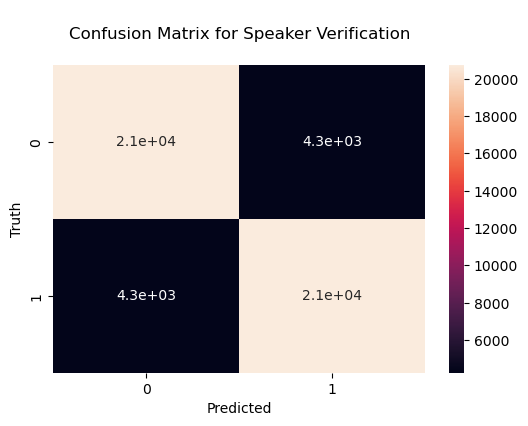

In [ ]:
print(f'Time taken for verification_score: {np.mean(speaker_verification.time):.6f} seconds')
Confusion_Matrix(speaker_verification.TP,speaker_verification.FP, speaker_verification.TN, speaker_verification.FN)